<a href="https://colab.research.google.com/github/djibril6/AI-Notebook/blob/main/DogVSCat_classifier_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Djibril ISSOUFOU

In this tutorial we will build a convolutional neural network for image binary classification using transfert learning method. For more undestanding this tutorial you can check this article: https://djib-ai.com/cnn-build-your-own-image-classification-system/

## Step 1: Getting the data

We use the dogs vs cats dataset from this kaggle competition: https://www.kaggle.com/biaiscience/dogs-vs-cats

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download  the dataset from [here](https://drive.google.com/file/d/1bvqNBfJlY5V595cUuavmSRHkADJU4lOm/view?usp=sharing) and move it to your drive. 
If the link is not active you can download the dataset from the [original source](https://www.kaggle.com/biaiscience/dogs-vs-cats) and then read our tutorial [here](https://djib-ai.com/convolutional-neural-network-build-your-own-dog-and-cat-image-classification-system-from-scratch/) to reorganize the data.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
zip_path = '/content/drive/MyDrive/blog/article 1/dataset/cats-vs-dogs.zip'
zip = zipfile.ZipFile(zip_path , "r")
zip.extractall("/tmp/cats-vs-dogs")
zip.close()

In [61]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory('/tmp/cats-vs-dogs/train',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 22000 files belonging to 2 classes.


In [7]:
validation_dataset = image_dataset_from_directory('/tmp/cats-vs-dogs/validation',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 3000 files belonging to 2 classes.


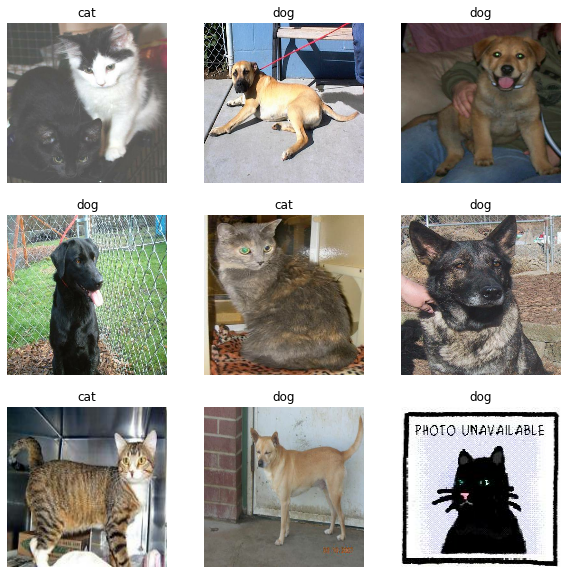

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## step 3: **Data** preprocessing

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 76
Number of test batches: 18


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## step 4: Model building

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


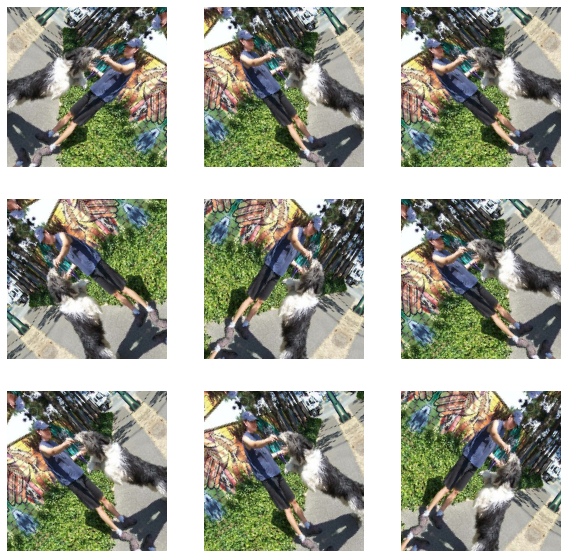

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - 0s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [19]:
base_model.trainable = False


In [20]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [24]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)


In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [26]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


76/76 [==============================] - 5s 35ms/step - loss: 0.7774 - accuracy: 0.5128


## step 5: Training

In [38]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)


Epoch 1/10
688/688 [==============================] - 32s 43ms/step - loss: 0.1203 - accuracy: 0.9513 - val_loss: 0.0526 - val_accuracy: 0.9818
Epoch 2/10
688/688 [==============================] - 29s 42ms/step - loss: 0.1154 - accuracy: 0.9501 - val_loss: 0.0537 - val_accuracy: 0.9839
Epoch 3/10
688/688 [==============================] - 29s 42ms/step - loss: 0.1182 - accuracy: 0.9498 - val_loss: 0.0534 - val_accuracy: 0.9827
Epoch 4/10
688/688 [==============================] - 29s 42ms/step - loss: 0.1140 - accuracy: 0.9532 - val_loss: 0.0511 - val_accuracy: 0.9847
Epoch 5/10
688/688 [==============================] - 30s 43ms/step - loss: 0.1169 - accuracy: 0.9515 - val_loss: 0.0541 - val_accuracy: 0.9835
Epoch 6/10
688/688 [==============================] - 30s 43ms/step - loss: 0.1137 - accuracy: 0.9527 - val_loss: 0.0510 - val_accuracy: 0.9839
Epoch 7/10
688/688 [==============================] - 30s 44ms/step - loss: 0.1097 - accuracy: 0.9548 - val_loss: 0.0508 - val_accuracy:

## step 6: Model evaluation

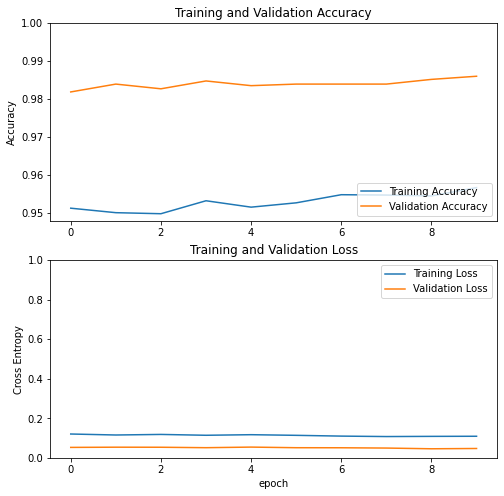

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Décongelez les couches supérieures du modèle

In [45]:
base_model.trainable = True


In [46]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [48]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [49]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [50]:
len(model.trainable_variables)


56

In [51]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
688/688 [==============================] - 39s 49ms/step - loss: 0.1028 - accuracy: 0.9587 - val_loss: 0.0539 - val_accuracy: 0.9810
Epoch 11/20
688/688 [==============================] - 34s 50ms/step - loss: 0.0848 - accuracy: 0.9660 - val_loss: 0.0401 - val_accuracy: 0.9868
Epoch 12/20
688/688 [==============================] - 35s 51ms/step - loss: 0.0769 - accuracy: 0.9676 - val_loss: 0.0433 - val_accuracy: 0.9856
Epoch 13/20
688/688 [==============================] - 35s 51ms/step - loss: 0.0752 - accuracy: 0.9707 - val_loss: 0.0400 - val_accuracy: 0.9864
Epoch 14/20
688/688 [==============================] - 36s 51ms/step - loss: 0.0689 - accuracy: 0.9731 - val_loss: 0.0421 - val_accuracy: 0.9868
Epoch 15/20
688/688 [==============================] - 35s 51ms/step - loss: 0.0597 - accuracy: 0.9757 - val_loss: 0.0410 - val_accuracy: 0.9860
Epoch 16/20
688/688 [==============================] - 35s 51ms/step - loss: 0.0589 - accuracy: 0.9765 - val_loss: 0.0385 - val_ac

In [62]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


TypeError: ignored

In [55]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs+5,
                         initial_epoch=20,
                         validation_data=validation_dataset)

Epoch 21/25
688/688 [==============================] - 33s 47ms/step - loss: 0.0437 - accuracy: 0.9835 - val_loss: 0.0476 - val_accuracy: 0.9839
Epoch 22/25
688/688 [==============================] - 32s 46ms/step - loss: 0.0435 - accuracy: 0.9830 - val_loss: 0.0413 - val_accuracy: 0.9856
Epoch 23/25
688/688 [==============================] - 32s 47ms/step - loss: 0.0424 - accuracy: 0.9837 - val_loss: 0.0467 - val_accuracy: 0.9843
Epoch 24/25
688/688 [==============================] - 32s 46ms/step - loss: 0.0395 - accuracy: 0.9853 - val_loss: 0.0447 - val_accuracy: 0.9864
Epoch 25/25
688/688 [==============================] - 32s 47ms/step - loss: 0.0367 - accuracy: 0.9859 - val_loss: 0.0443 - val_accuracy: 0.9872


In [60]:
model.save('/home/my_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [59]:
history_fine = model.fit(train_dataset,
                         epochs=35,
                         initial_epoch=30,
                         validation_data=validation_dataset)

Epoch 31/35
688/688 [==============================] - 34s 50ms/step - loss: 0.0286 - accuracy: 0.9888 - val_loss: 0.0386 - val_accuracy: 0.9872
Epoch 32/35
688/688 [==============================] - 34s 49ms/step - loss: 0.0301 - accuracy: 0.9888 - val_loss: 0.0413 - val_accuracy: 0.9897
Epoch 33/35
688/688 [==============================] - 34s 49ms/step - loss: 0.0284 - accuracy: 0.9890 - val_loss: 0.0565 - val_accuracy: 0.9851
Epoch 34/35
688/688 [==============================] - 34s 49ms/step - loss: 0.0243 - accuracy: 0.9911 - val_loss: 0.0368 - val_accuracy: 0.9897
Epoch 35/35
688/688 [==============================] - 34s 49ms/step - loss: 0.0242 - accuracy: 0.9909 - val_loss: 0.0782 - val_accuracy: 0.9814


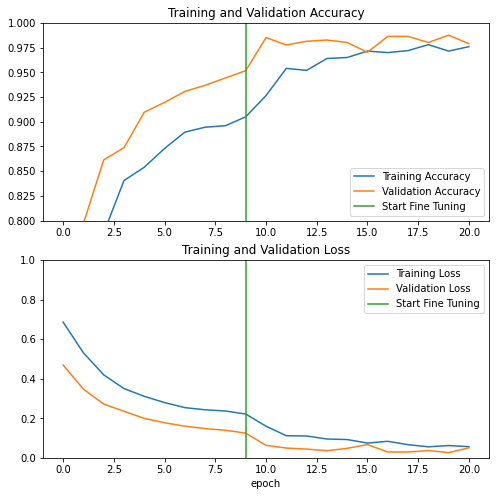

In [162]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Évaluation et prédiction

In [64]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


18/18 [==============================] - 1s 38ms/step - loss: 0.0800 - accuracy: 0.9809
Test accuracy : 0.9809027910232544


Predictions:
 [0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1]
Labels:
 [0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1]


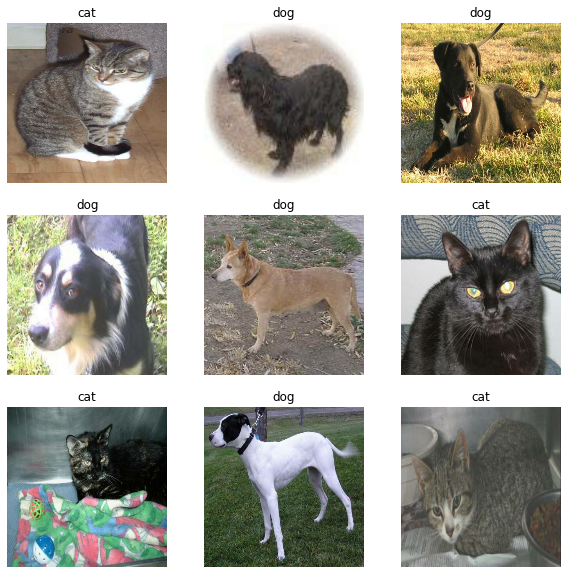

In [65]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [44]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

allupload=files.upload()

for file_name in allupload.keys():
  path='/content/' + file_name
  img=image.load_img(path, target_size=(160, 160))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  if classes[0]>0:
    print(file_name + " is a dog")
    
  else:
    print(file_name + " is a cat")

Saving taylor-swift-cats.jpg to taylor-swift-cats.jpg
taylor-swift-cats.jpg is a cat
